# ImageJ in Python

This notebook shows how to use ImageJ as a Python library and uses the OMERO Python API to connect to an OMERO server.

In this setup, Fiji has already been installed. 
We will use the [pyimagej](https://pypi.org/project/pyimagej/) library to access to the entire ImageJ API from Python.

## Packages

In [1]:
import numpy

import imagej
from omero.gateway import BlitzGateway

## Starting ImageJ from Python

In [2]:
ij = imagej.init('/srv/conda/vnc/Fiji.app', headless=False) # we use headless=False to show how run a macro
ij.getVersion()

'2.0.0-rc-69/1.52p'

## Connect to IDR

In [3]:
def connect(hostname, username, password):
    """
    Connect to an OMERO server
    :param hostname: Host name
    :param username: User
    :param password: Password
    :return: Connected BlitzGateway
    """
    conn = BlitzGateway(username, password,
                        host=hostname, secure=True)
    conn.connect()
    conn.c.enableKeepAlive(60)
    return conn

conn = connect("ws://idr.openmicroscopy.org/omero-ws", "public", "public")
print("Connected as {}".format(conn.getUser().getName()))

Connected as public


## Load an image from IDR 

In [4]:
image_id = 1884835
image = conn.getObject("Image", image_id)

## Load binary data from IDR

We load the image as a 5D numpy array as tzcyx. 

In [5]:
def load_numpy_array(image):
    pixels = image.getPrimaryPixels()
    size_z = image.getSizeZ()
    size_c = image.getSizeC()
    size_t = image.getSizeT()
    size_y = image.getSizeY()
    size_x = image.getSizeX()
    z, t, c = 0, 0, 0  # first plane of the image
    zct_list = []
    for t in range(size_t):
        for z in range(size_z):  # get the Z-stack
            for c in range(size_c):  # all channels
                    zct_list.append((z, c, t))
    values = []
    # Load all the planes as YX numpy array
    planes = pixels.getPlanes(zct_list)
    j = 0
    k = 0
    tmp_c = []
    tmp_z = []
    s = "z:%s t:%s c:%s y:%s x:%s" % (size_z, size_t, size_c, size_y, size_x)
    print(s)
    # axis tzcyx
    print("Downloading image %s" % image.getName())
    for i, p in enumerate(planes):
        if k < size_z:
            if j < size_c:
                tmp_c.append(p)
                j = j + 1
            if j == size_c:
                # use dstack to have c at the end
                tmp_z.append(numpy.stack(tmp_c))
                tmp_c = []
                j = 0
                k = k + 1
        if k == size_z:  # done with the stack
            values.append(numpy.stack(tmp_z))
            tmp_z = []
            k = 0

    return numpy.stack(values)

img = load_numpy_array(image)
print(img.shape)

z:1 t:1 c:2 y:256 x:256
(1, 1, 2, 256, 256)


## Display image using `ij.py.show()`

(1, 1, 256, 256)


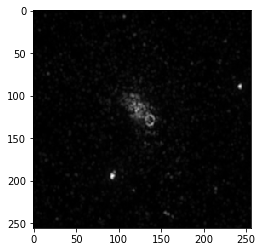

In [6]:
img_new = numpy.mean(img, axis=2)
print(img_new.shape)
ij.py.show(img_new[0, 0, :, :], cmap = 'gray')

## Process numpy arrays in ImageJ

We use the method `to_java()` to convert into ImageJ types.

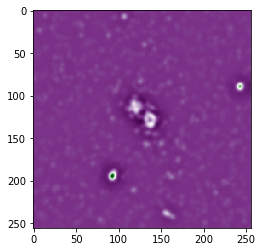

In [7]:
img = img[0, 0, 0, :, :]
result = numpy.zeros(img.shape)
sigma1 = 8
sigma2 = 2
# note the use of to_java on img and result to turn the numpy images into RAIs
ij.op().filter().dog(
    ij.py.to_java(result),
    ij.py.to_java(img),
    sigma1,
    sigma2)
# purple highlights the edges of the vessels, green highlights the centers
ij.py.show(result, cmap = 'PRGn')

## Run macro

Run a macro on the image. We use ImageJ1 windows so it requires using ImageJ in GUI mode and requires handling the resulting windows.

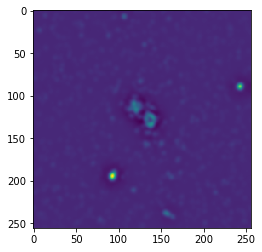

In [8]:
from jnius import autoclass
WindowManager = autoclass('ij.WindowManager')

ij.ui().show('Image', ij.py.to_java(img))
macro = """
run("8-bit");
"""
ij.py.run_macro(macro)

img = WindowManager.getCurrentImage()
img.changes = False
ij.py.show(result)

## Close the connection to IDR

In [9]:
conn.close()